# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
sns.set(style="darkgrid")
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

## Загрузка и подготовка данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.head(3)

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27


In [4]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Дубликаты

In [7]:
print(f"Количество дублирующихся id в регионе 0: {geo_data_0['id'].value_counts().pipe(lambda x: x[x>=2]).count()}")
print(f"Количество дублирующихся id в регионе 1: {geo_data_1['id'].value_counts().pipe(lambda x: x[x>=2]).count()}")
print(f"Количество дублирующихся id в регионе 2: {geo_data_2['id'].value_counts().pipe(lambda x: x[x>=2]).count()}")

Количество дублирующихся id в регионе 0: 10
Количество дублирующихся id в регионе 1: 4
Количество дублирующихся id в регионе 2: 4


<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Мы видим, что в данных каждого региона есть дублирующиеся id
    Непонятно, это разные скважины случайно получили одно и то же id, или это данные по одной и той же скважине в разное время?
    
    С учетом того, что таких данных не много, удалим их
    
</div>

In [8]:
print(f'размер датасета geo_data_0 до удаления дубликатов {geo_data_0.shape}')
print(f'размер датасета geo_data_1 до удаления дубликатов {geo_data_1.shape}')
print(f'размер датасета geo_data_2 до удаления дубликатов {geo_data_2.shape}\n')

geo_data_0 = geo_data_0.drop_duplicates('id').reset_index(drop = True)
geo_data_1 = geo_data_1.drop_duplicates('id').reset_index(drop = True)
geo_data_2 = geo_data_2.drop_duplicates('id').reset_index(drop = True)

print(f'размер датасета geo_data_0 после удаления дубликатов {geo_data_0.shape}')
print(f'размер датасета geo_data_1 после удаления дубликатов {geo_data_1.shape}')
print(f'размер датасета geo_data_2 после удаления дубликатов {geo_data_2.shape}')

размер датасета geo_data_0 до удаления дубликатов (100000, 5)
размер датасета geo_data_1 до удаления дубликатов (100000, 5)
размер датасета geo_data_2 до удаления дубликатов (100000, 5)

размер датасета geo_data_0 после удаления дубликатов (99990, 5)
размер датасета geo_data_1 после удаления дубликатов (99996, 5)
размер датасета geo_data_2 после удаления дубликатов (99996, 5)


### Масштаб признаков

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Посмотрим масштаб признаков f0, f1, f2
    
</div>

In [9]:
def dist_priznak(priznak):
    plt.subplots(figsize = (10,6))
    sns.distplot(geo_data_0[priznak], color="skyblue", label="region1", kde=True)
    sns.distplot(geo_data_1[priznak], color="red"    , label="region2", kde=True)
    sns.distplot(geo_data_2[priznak], color="green"    , label="region3", kde=True)
    plt.title(f'Гистограмма признака {priznak} по регионам', fontsize = 15);
    plt.xlabel(priznak, fontsize = 12)
    plt.legend();

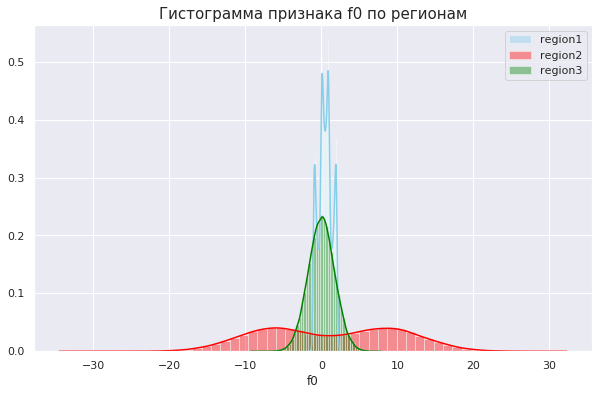

In [10]:
dist_priznak('f0')

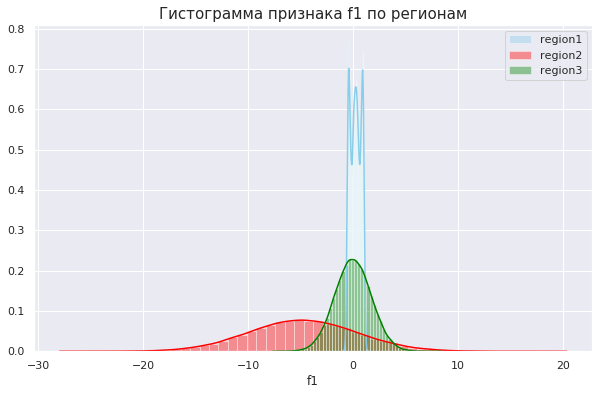

In [11]:
dist_priznak('f1')

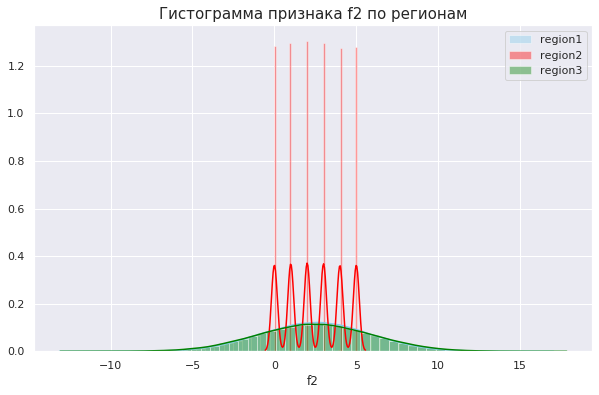

In [12]:
dist_priznak('f2')

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Видим, что масштаб всех трех признаков сопоставимый, поэтому масштабирование применять не будем
    
</div>

## Обучение и проверка модели

In [14]:
def split_features_target(data, target, test_size=0.25, drop_col=None):
    
    name =[x for x in globals() if globals()[x] is data][0]
    if drop_col:
        data = data.drop(drop_col, axis=1)

    data_train, data_valid = train_test_split(data, test_size=test_size, random_state=12345)
    
    print(f'Размер исходной выборки в датасете {name}: {data.shape}')
    print(f'Размер обучающей выборки, полученной из датасета {name}: {data_train.shape}')
    print(f'Размер валидационной выборки, полученной из датасета {name}: {data_valid.shape}')
    print()

    features_train = data_train.drop(target, axis=1)
    target_train = data_train[target]
    features_valid = data_valid.drop(target, axis=1)
    target_valid = data_valid[target]
    
    return features_train, target_train, features_valid, target_valid

In [15]:
features_train_0, target_train_0, features_valid_0, target_valid_0 = split_features_target(data=geo_data_0, target='product', drop_col='id')
features_train_1, target_train_1, features_valid_1, target_valid_1 = split_features_target(data=geo_data_1, target='product', drop_col='id')
features_train_2, target_train_2, features_valid_2, target_valid_2 = split_features_target(data=geo_data_2, target='product', drop_col='id')

Размер исходной выборки в датасете geo_data_0: (99990, 4)
Размер обучающей выборки, полученной из датасета geo_data_0: (74992, 4)
Размер валидационной выборки, полученной из датасета geo_data_0: (24998, 4)

Размер исходной выборки в датасете geo_data_1: (99996, 4)
Размер обучающей выборки, полученной из датасета geo_data_1: (74997, 4)
Размер валидационной выборки, полученной из датасета geo_data_1: (24999, 4)

Размер исходной выборки в датасете geo_data_2: (99996, 4)
Размер обучающей выборки, полученной из датасета geo_data_2: (74997, 4)
Размер валидационной выборки, полученной из датасета geo_data_2: (24999, 4)



In [16]:
def model_profit(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_model = model.predict(features_valid)
    predict_model = pd.Series(predict_model, index=target_valid.index)
    rmse_model = mean_squared_error(target_valid, predict_model)**0.5
    
    predict_mean = pd.Series(target_train.mean(), index=target_valid.index)
    rmse_mean = mean_squared_error(target_valid, predict_mean)**0.5
    
    return model, predict_model, rmse_model, rmse_mean

In [17]:
model_0, predict_0, rmse_0, rmse_mean_0 = model_profit(features_train_0, target_train_0, features_valid_0, target_valid_0)
model_1, predict_1, rmse_1, rmse_mean_1 = model_profit(features_train_1, target_train_1, features_valid_1, target_valid_1)
model_2, predict_2, rmse_2, rmse_mean_2 = model_profit(features_train_2, target_train_2, features_valid_2, target_valid_2)

In [18]:
print(f'RMSE модели в регионе 0: {rmse_0}')
print(f'RMSE модели, в регионе 0 если предсказывать средним числом : {rmse_mean_0}')
print()
print(f'RMSE модели в регионе 1: {rmse_1}')
print(f'RMSE модели, в регионе 1 если предсказывать средним числом : {rmse_mean_1}')
print()
print(f'RMSE модели в регионе 2: {rmse_2}')
print(f'RMSE модели, в регионе 2 если предсказывать средним числом : {rmse_mean_2}')

RMSE модели в регионе 0: 37.853527328872964
RMSE модели, в регионе 0 если предсказывать средним числом : 44.379313806074194

RMSE модели в регионе 1: 0.892059264771702
RMSE модели, в регионе 1 если предсказывать средним числом : 45.903263550206404

RMSE модели в регионе 2: 40.07585073246016
RMSE модели, в регионе 2 если предсказывать средним числом : 44.68331298360565


## Подготовка к расчёту прибыли

In [19]:
PRICE = 450000
BUDGET_RERION = 10*10**9

In [20]:
SAMPLE_SIZE_BEST_WELL = 200
SAMPLE_SIZE_WELL = 500

### Безубыточный объем скважины

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Разделив общий бюджет на количество скважин, получим бюджет на одну скважину.
    Разделив бюджет на одну скважину на цену продукта, получим безубыточный объем скважины
    
</div>

In [21]:
VOLUME_OIL_WELL = BUDGET_RERION / SAMPLE_SIZE_BEST_WELL / PRICE
VOLUME_OIL_WELL

111.11111111111111

<div style="border:solid gray 2.0px; padding: 10px"> 
    
**Вывод:**

Безубыточный объем скважины равен 111.11 тыс. баррелей.
    
    
</div>

## Расчёт прибыли и рисков 

### Функция для расчета прибыли

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Функция revenue расчитывает потенциальную прибыль региона от бурения заданного количества лучших с точки зрения предсказания объема сырья скважин.
    
Получает на вход выбранные скважины, предсказания объема сырья в них, и количество отбираемых скважин.

Возвращает совокупный предполагаемый доход в результате освоения отобранных скважин

    
</div>

In [34]:
def profit(target, predict, count=200, price=PRICE, budget_region=BUDGET_RERION):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]

    return (price * selected.sum()) - budget_region

### Расчет прибыли

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Создадим и наполним словарь, ключами которого будут регионы, а значениями показатели прибыли, полученные техникой Bootsrap
    
</div>

In [36]:
state = np.random.RandomState(12345)
def profit_region(target_valid, predict, items=1000, state=state, sample_size_well=SAMPLE_SIZE_WELL, sample_size_best_well=SAMPLE_SIZE_BEST_WELL):
    profit_region=[]
    for i in range(items):
        target_subsample = target_valid.sample(frac=1/len(target_valid)*sample_size_well, replace=True, random_state=state)
        predict_subsample = predict[target_subsample.index]
        profit_region.append(profit(target_subsample, predict_subsample, sample_size_best_well))
    return profit_region

In [37]:
profit_dict = dict()
profit_dict['region0'] = profit_region(target_valid_0, predict_0)
profit_dict['region1'] = profit_region(target_valid_1, predict_1)
profit_dict['region2'] = profit_region(target_valid_2, predict_2)

<div style="border:solid gray 2.0px; padding: 10px"> 
    
    Построим распределение прибыли по регионам, чтобы оценить ее визуально
    
</div>

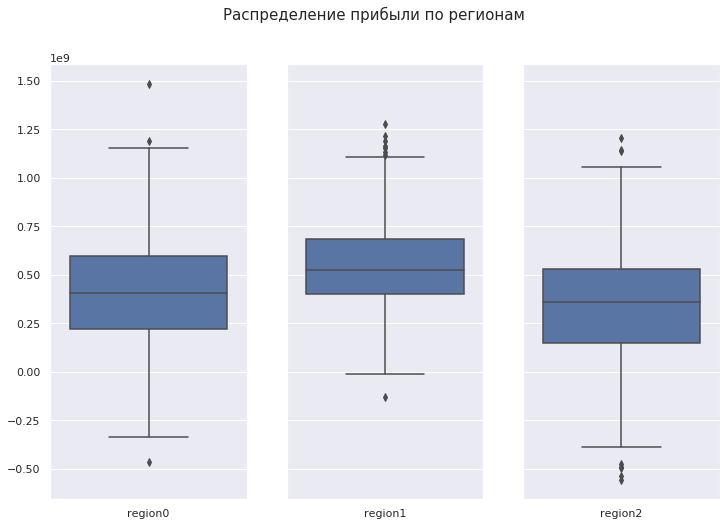

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
for axnum, (region, profits) in enumerate(profit_dict.items()):
    data = pd.DataFrame(profits, columns=[region])    
    ax = sns.boxplot(ax=axes[axnum], data = data)

fig.suptitle('Распределение прибыли по регионам', fontsize=15);

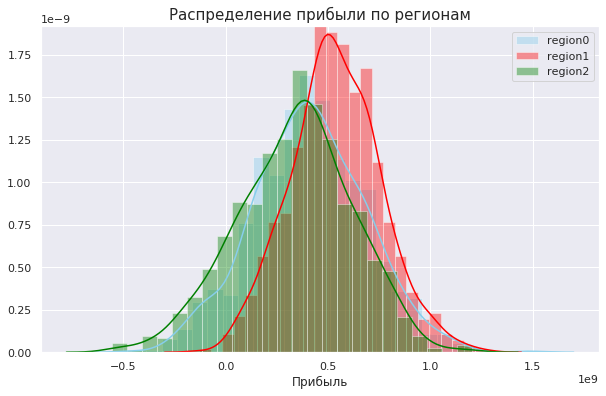

In [39]:
plt.subplots(figsize = (10,6))
sns.distplot(pd.Series(profit_dict['region0']), color="skyblue", label="region0", kde=True)
sns.distplot(pd.Series(profit_dict['region1']), color="red"    , label="region1", kde=True)
sns.distplot(pd.Series(profit_dict['region2']), color="green"  , label="region2", kde=True)
plt.title(f'Распределение прибыли по регионам', fontsize = 15);
plt.xlabel('Прибыль', fontsize = 12)
plt.legend();

In [40]:
profits_reg = pd.DataFrame(columns=['region', 'mean', 'conf_int', 'risk_loss'])
for region, profits in profit_dict.items():
    profits_reg.loc[len(profits_reg)] = [
        region, 
        np.mean(profits), 
        (pd.Series(profits).quantile(0.025), pd.Series(profits).quantile(0.975)),
        (pd.Series(profits)<0).mean()*100
    ]
#        pd.Series(profits).pipe(lambda x: x[x<0]).count() / pd.Series(profits).count()*100
    

In [41]:
profits_reg

,region,mean,conf_int,risk_loss
0,region0,"409,428,038.62","(-131536028.70166382, 944395582.7546725)",7.10
1,region1,"536,400,199.44","(112954247.12370129, 998504156.6468805)",0.30
2,region2,"339,478,034.20","(-224089221.74407586, 847067587.6863929)",11.80


### Вывод

<div class="alert alert-block alert-warning">

    
**Вывод:**
    
Риски убытков в каждом регионе разные:
 - region0: 7.1%
 - region1: 0.3%
 - region2: 11.8%
    
Рекомендуемый регион 1: доля риска 0.3%. Это единственный регион с долей риска меньше 2.5% (заданного максимального порога)
    
    
</div>